## The Sparks Foundation-GRIP-Data Science and Business Analytics-August'2021
### Task 4: Detection of face mask
### Author: Saifur Rahman Shatil

#### Importing Libraries

In [1]:
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2 
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout,GlobalAveragePooling2D, Activation, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from keras import models, layers, optimizers
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,Callback, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
random.seed(180)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

/kaggle/input
/kaggle/input/face-mask-12k-images-dataset
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask


#### Data Paths

In [3]:
traindir='../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
validdir='../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'
testdir='../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'

In [4]:
myList = os.listdir(traindir)
print("Total Number of Classes Detected :",len(myList))
noOfclasses= len(myList)
print(myList)

Total Number of Classes Detected : 2
['WithoutMask', 'WithMask']


#### Visualizing Data

Images With Mask


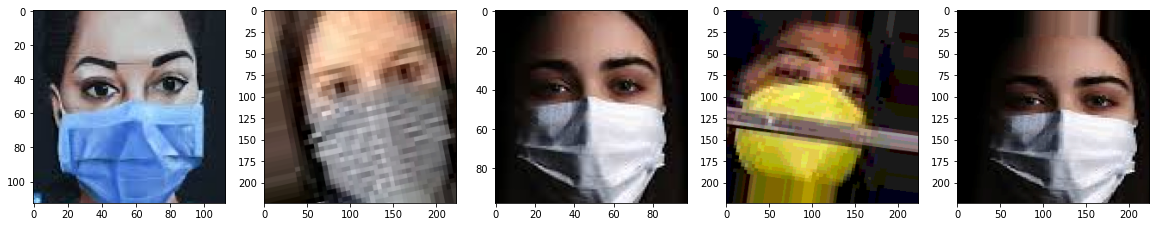

In [5]:
path1='../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask'

print("Images With Mask")
plt.figure(figsize=(20,10))
for i in range(5):
    file=random.choice(os.listdir(path1))
    img_path=os.path.join(path1,file)
    image=cv2.imread(img_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax=plt.subplot(1,5,i+1)
    plt.imshow(image)

Images Without Mask


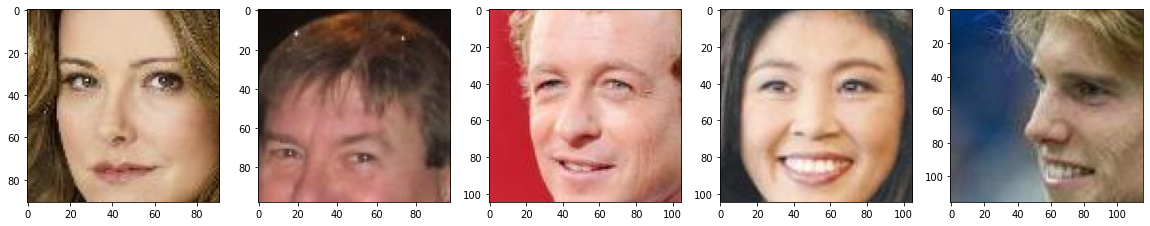

In [6]:
path2='../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask'

print("Images Without Mask")
plt.figure(figsize=(20,10))
for i in range(5):
    file=random.choice(os.listdir(path2))
    img_path=os.path.join(path2,file)
    image=cv2.imread(img_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax=plt.subplot(1,5,i+1)
    plt.imshow(image)

#### Loading Data

In [7]:
classes=['WithMask','WithoutMask']
print("Importing Dataset...")

Importing Dataset...


In [8]:
def load_data(image_list,label_list,path):
    classes=['WithMask','WithoutMask']
    for category in classes:
        picList= os.listdir(path+"/"+str(category))
        for pic in tqdm(picList):
            image= cv2.imread(path+"/"+str(category)+"/"+pic)
            image= cv2.resize(image,(128,128))
            image = img_to_array(image)/255.0
            image_list.append(image)
            label_list.append(classes.index(category))
    return image_list,label_list

In [9]:
train_images=[]
train_labels=[]
train_images,train_labels= load_data(train_images,train_labels,traindir)

100%|██████████| 5000/5000 [00:23<00:00, 211.91it/s]


In [10]:
val_images=[]
val_labels=[]
val_images,val_labels= load_data(val_images,val_labels,validdir)

100%|██████████| 400/400 [00:01<00:00, 218.99it/s]


In [11]:
test_images=[]
test_labels=[]
test_images,test_labels= load_data(test_images,test_labels,testdir)

100%|██████████| 509/509 [00:02<00:00, 216.28it/s]


#### Convert to NumPy array

In [12]:
def convert_to_array(train_images,train_labels):
    images = np.array(train_images)
    labels = np.array(train_labels)
    return images,labels

In [13]:
x_train,y_train= convert_to_array(train_images,train_labels)
x_val,y_val= convert_to_array(val_images,val_labels)
x_test,y_test= convert_to_array(test_images,test_labels)

In [14]:
del train_images
del train_labels
del val_images
del val_labels
del test_images
del test_labels

In [15]:
print(x_train.shape, y_train.shape, type(x_train), x_train.dtype,y_train.dtype)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(10000, 128, 128, 3) (10000,) <class 'numpy.ndarray'> float32 int64
(800, 128, 128, 3) (800,)
(992, 128, 128, 3) (992,)


#### One hot encoding

In [16]:
print(y_train[650])
print(y_val[650])
print(y_test[650])

0
1
1


In [17]:
y_train= to_categorical(y_train)
y_val= to_categorical(y_val)
y_test= to_categorical(y_test)

In [18]:
print(y_train[650])
print(y_val[650])
print(y_test[650])

[1. 0.]
[0. 1.]
[0. 1.]


#### Image Augmentation

In [19]:
augmentation = ImageDataGenerator(  
    height_shift_range= 0.2, 
    width_shift_range=0.2, 
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Model Callbacks

In [20]:
file_path="./model_weight.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor="val_loss", mode='auto', patience=10,restore_best_weights=True)
callbacks_list = [checkpoint,early]

#### CNN Model Creation

In [21]:
model5=Sequential()
model5.add(Conv2D(32,(3,3),activation='relu', input_shape=(128, 128, 3),padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(32,(3,3),activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))


model5.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))


model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))
model5.add(Dense(2,activation='softmax'))
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

#### Model Visualization

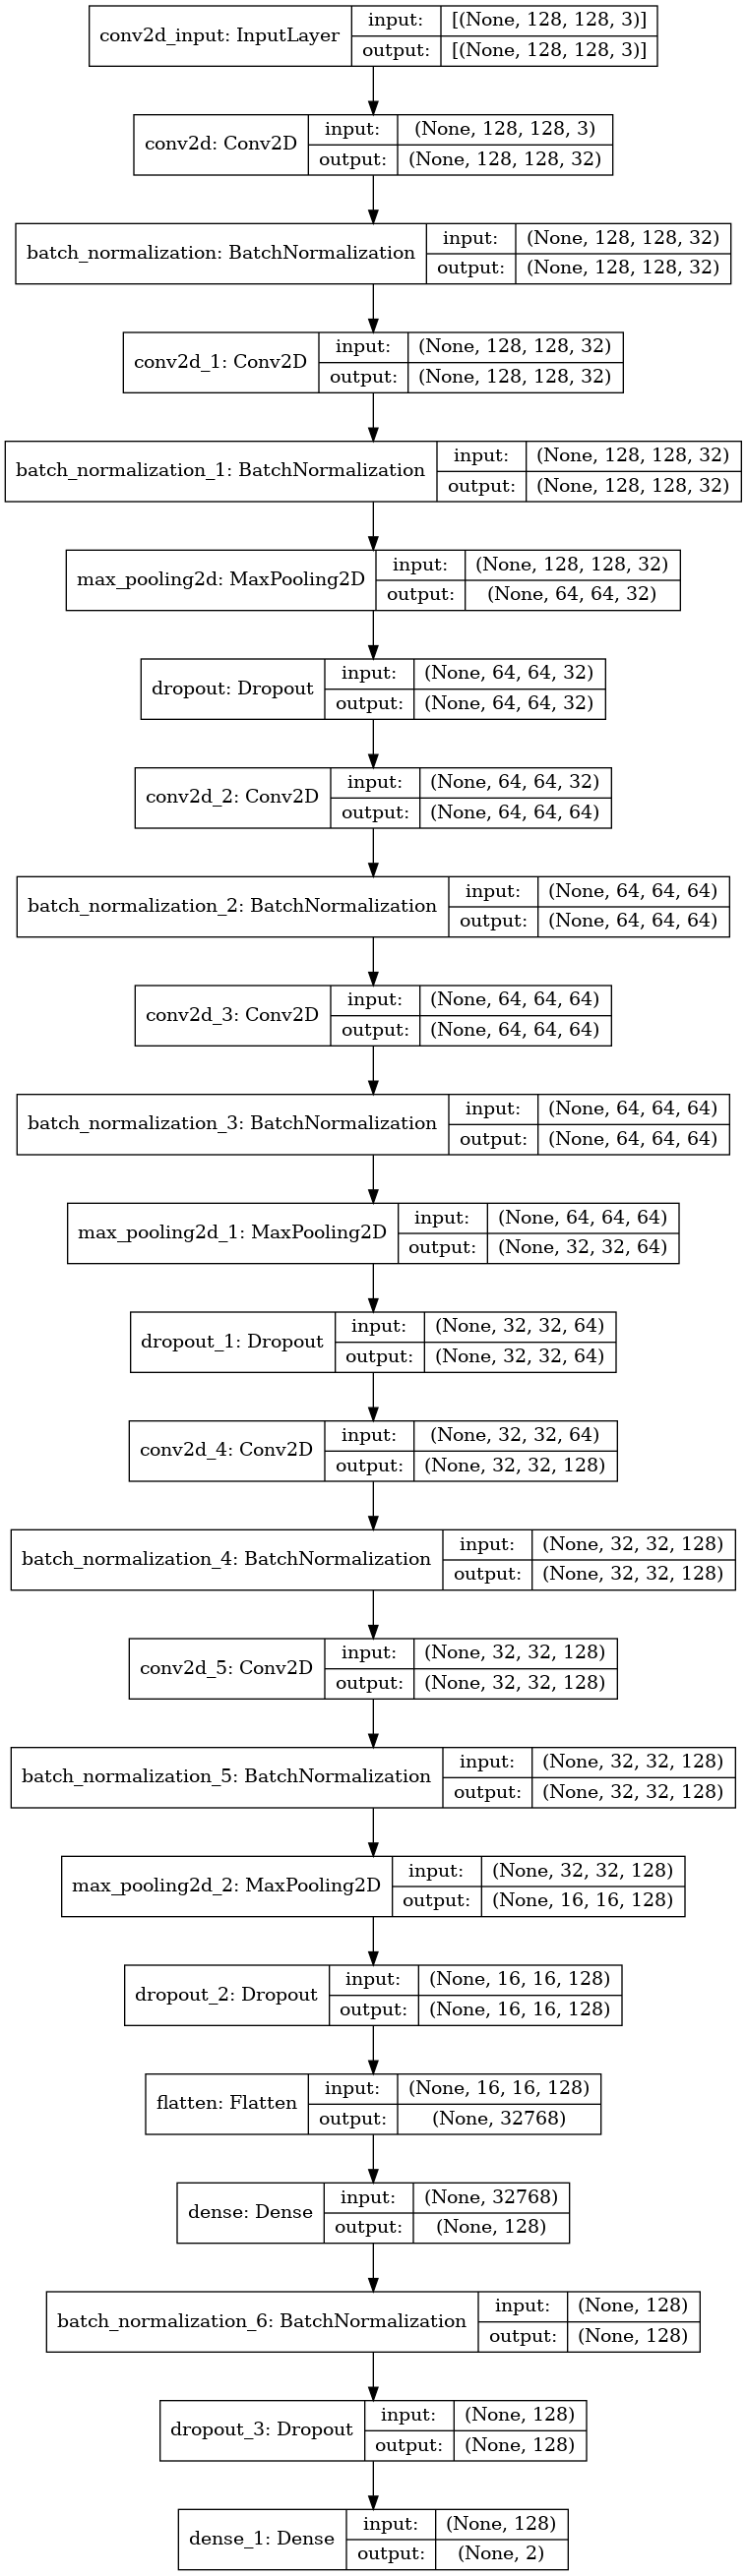

In [22]:
model_img_file = './model_image.png'
tf.keras.utils.plot_model(model5, to_file=model_img_file, show_shapes=True, show_layer_names=True)

#### Model Compiling and Training

In [23]:
INIT_LR=0.0001
EPOCHS=100
BS=32
model5.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001,decay= INIT_LR/EPOCHS),metrics=['accuracy'])

In [24]:
from sklearn.utils import shuffle
x_val,y_val= shuffle(x_val,y_val)

In [25]:
history = model5.fit(
    augmentation.flow(x_train,y_train,batch_size=BS,shuffle=True),
    steps_per_epoch= len(x_train)//BS,
    validation_data=(x_val,y_val),
    validation_steps= len(x_val)//BS,
    epochs= EPOCHS,
    callbacks=[callbacks_list],
    verbose=1
)

Epoch 1/100
312/312 [==============================] - 48s 129ms/step - loss: 0.2759 - accuracy: 0.8900 - val_loss: 1.7896 - val_accuracy: 0.5050

Epoch 00001: val_loss improved from inf to 1.78958, saving model to ./model_weight.hdf5
Epoch 2/100
312/312 [==============================] - 40s 127ms/step - loss: 0.1507 - accuracy: 0.9467 - val_loss: 0.2043 - val_accuracy: 0.9450

Epoch 00002: val_loss improved from 1.78958 to 0.20427, saving model to ./model_weight.hdf5
Epoch 3/100
312/312 [==============================] - 41s 132ms/step - loss: 0.1151 - accuracy: 0.9604 - val_loss: 0.0768 - val_accuracy: 0.9812

Epoch 00003: val_loss improved from 0.20427 to 0.07683, saving model to ./model_weight.hdf5
Epoch 4/100
312/312 [==============================] - 40s 128ms/step - loss: 0.1023 - accuracy: 0.9643 - val_loss: 0.0665 - val_accuracy: 0.9862

Epoch 00004: val_loss improved from 0.07683 to 0.06649, saving model to ./model_weight.hdf5
Epoch 5/100
312/312 [===========================

#### Accuracy and Loss Curve

In [26]:
def plot_learning_curve(history):
    plt.figure(figsize=(18,9))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('./loss_curve.png')

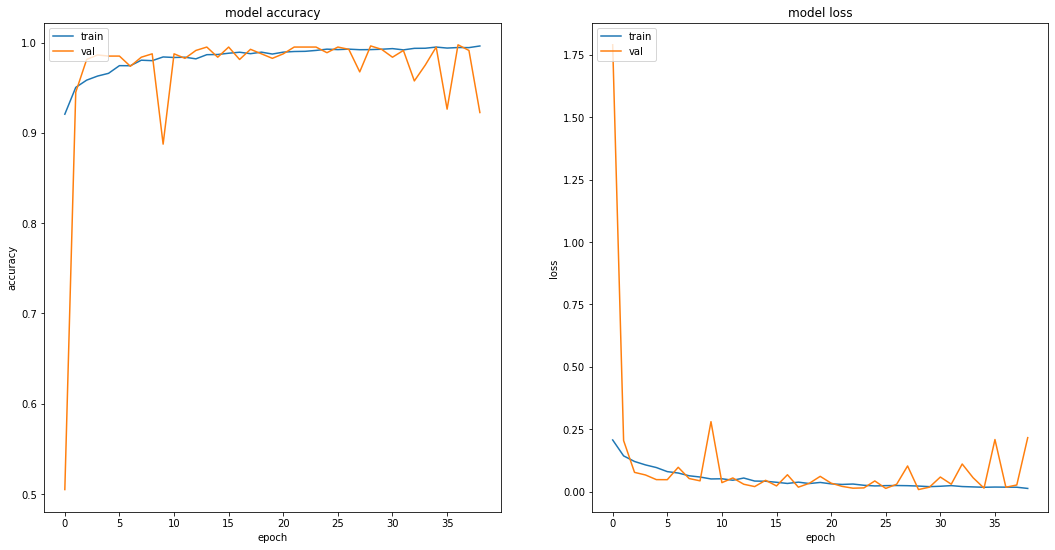

In [27]:
plot_learning_curve(history)
plt.show()

#### Model Evaluation

In [28]:
model5.load_weights("./model_weight.hdf5")
score=model5.evaluate(x_test,y_test)
print("Loss: {} \t\tAccuracy: {}".format(score[0],score[1]))

31/31 [==============================] - 0s 9ms/step - loss: 0.0197 - accuracy: 0.9960
Loss: 0.019706234335899353 		Accuracy: 0.9959677457809448


In [29]:
y_pred = model5.predict(x_test,batch_size=BS)
Y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred,target_names=['WithMask','WithoutMask']))

              precision    recall  f1-score   support

    WithMask       0.99      1.00      1.00       483
 WithoutMask       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./confusion_matrix.png')

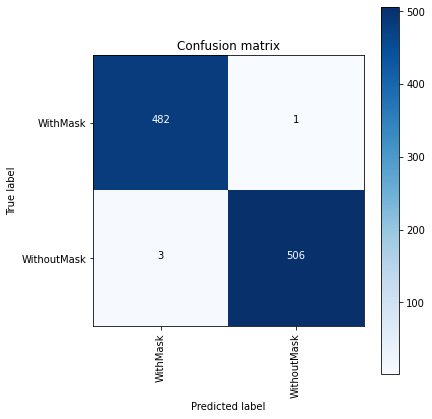

In [32]:
# confusion matrix
cm = confusion_matrix(Y_true, Y_pred)        
# plot confusin matrix
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['WithMask','WithoutMask'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [33]:
model5.save('./face_model.h5')

#### Load the model

In [34]:
# from keras import models
# loaded_model = models.load_model('./face_model.h5')
# score=loaded_model.evaluate(x_test,y_test)
# print(score[1])

#### Predicting Image Mask or No Mask

In [35]:
x_test[98]

array([[[0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.49019608, 0.6862745 ],
        ...,
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ]],

       [[0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.48235294, 0.6862745 ],
        ...,
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ]],

       [[0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.48235294, 0.6862745 ],
        [0.37254903, 0.48235294, 0.6862745 ],
        ...,
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ]],

       ...,

       [[0.2784314 , 0.30980393, 0.3882353 ],
        [0.28235295, 0.30980393, 0.3882353 ],
        [0.30980393, 0

In [36]:
y_test[98]

array([1., 0.], dtype=float32)

In [37]:
face = np.expand_dims(x_test[98], axis=0)
(mask, withoutMask) = model5.predict(face)[0]
label = "Mask" if mask > withoutMask else "No Mask"
print(label)

Mask


In [38]:
y_test[790]

array([0., 1.], dtype=float32)

In [39]:
face = np.expand_dims(x_test[790], axis=0)
(mask, withoutMask) = model5.predict(face)[0]
label = "Mask" if mask > withoutMask else "No Mask"
print(label)

No Mask


#### Prediction From Manual Input 
Uncomment the code below to run.

In [40]:
# path=input()
# image= cv2.imread(path)
# image= cv2.resize(image,(128,128))
# image = img_to_array(image)/255.0
# image=np.array(image)
# image = np.expand_dims(image, axis=0)
# (mask, withoutMask) = model5.predict(image)[0]
# print(mask,withoutMask)
# label = "Mask" if mask > withoutMask else "No Mask"
# print(label)

#### Conclusion
Created and trained a CNN model to detect face mask in images. The model obtained an accuracy of 99.7%.

### If the kernel impress you,give an <font size="+3" color="blue"><b>Upvote</b></font>.<br>